<a href="https://colab.research.google.com/github/jkjh23/BusanAIDeveloperCourse_AI_FinalProject/blob/main/Preliminary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 불러오기

- [GPU 사용해서 SVM 돌리기](https://www.kaggle.com/c/2019-ml-finalproject/discussion/119011)

In [ ]:
# GPU 사용 -> CPU랑 비슷한 듯
# !pip install cupy

     |████████████████████████████████| 5.8MB 7.0MB/s 
  Created wheel for cupy: filename=cupy-8.0.0-cp36-cp36m-linux_x86_64.whl size=53454164 sha256=68888aefe3ba2886735b2082071345be2d514bea46e64dd338828b77f126a3dd
  Stored in directory: /root/.cache/pip/wheels/fb/71/09/27324d415f534f11b3c8d575efee0127268b09639841ee93c0
Successfully built cupy


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import f1_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import plot_importance

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, backend
from tensorflow.keras.utils import *
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dense, Activation, Embedding, LSTM, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from keras import initializers

# import cupy as xp
import warnings 
from tqdm import tqdm_notebook, tqdm
import time
import cv2
import copy

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
df = pd.read_csv('/content/drive/My Drive/2020_AI_Contest/Data/train/train.tsv', sep='\t', names=['file_name', 'plant_label', 'disease_label'])
df

In [ ]:
warnings.filterwarnings(action='ignore')
df['class_label'] = 'Nan'

comb = [(df.plant_label[i], df.disease_label[i]) for i in range(0,df.shape[0])]
combUnique = []
for v in comb:
    if v not in combUnique:
        combUnique.append(v)

for i in range(0,df.shape[0]) :
    df['class_label'][i] = combUnique.index((df.plant_label[i], df.disease_label[i]))

df = df.loc[:, ['file_name', 'class_label']]
df

,file_name,class_label
0,3_5_1123.jpg,0
1,3_20_1048.jpg,1
2,4_2_401.jpg,2
3,4_7_740.jpg,3
4,4_11_93.jpg,4
...,...,...
15995,13_15_1600.jpg,15
15996,13_16_1570.jpg,16
15997,13_17_986.jpg,17
15998,13_18_4980.jpg,18


In [ ]:
!nvidia-smi

Tue Oct 27 17:15:01 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
testDf = pd.read_csv('/content/drive/My Drive/2020_AI_Contest/Data/test/test.tsv', sep='\t', names=['file_name', 'plant_label', 'disease_label'])
testDf

## 이미지 확인

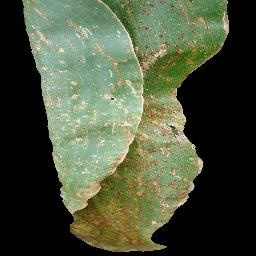

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img

In [ ]:
type(img), np.array(img).shape, img.size

(PIL.JpegImagePlugin.JpegImageFile, (256, 256, 3), (256, 256))

# SVM

## 전체 데이터 - 컬러 - 학습

|단위|커널|C|GPU|소요시간|f1 score|기타|
|--|--|--|:--:|--|--|--|
|100개|rbf|1||1:44:32|0.12||
|200개|rbf|1||2:51:45|0.31 ~ 0.36|linear 커널이 더 괜찮음|
|200개|linear|1||41:23|0.38 ~ 0.40||
|200개|linear|10||2:37:57|0.4 ~ 0.51||
|400개|linear|1||2:00:49|0.34 ~ 0.42||
|400개|linear|1|O|3:03:50||CPU보다 시간이 더 오래 걸림|
|1000개|linear|0.1||4:15:11|0.09 ~ 0.2||

### 100개, rbf

In [ ]:
model = SVC()

for muldf in tqdm_notebook(range(0,160)) :
  num = 100 * muldf
  dfPart = df[num:num+100]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

# 소요시간 1:44:43

In [ ]:
# joblib.dump(model, 'entire_color.pkl') 

['entire_color.pkl']

In [ ]:
# 드라이브에 저장
# joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color.pkl') 

['/content/drive/My Drive/2020_AI_Contest/entire_color.pkl']

In [ ]:
# model = joblib.load('entire_color.pkl') 

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

df = df[4300:5300].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((df.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, df.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + df.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((df.shape[0],))
for i in range(0, df.shape[0]) :
    y[i] = df['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

In [ ]:
pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

# 0.1268319997053765 => 결과가 쓰레기다

0.1268319997053765

### 200개, linear

In [ ]:
model = SVC(kernel='linear')
 
val1 = 200
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

# 소요시간 41:23

In [ ]:
# joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color_200_linear.pkl')

['/content/drive/My Drive/2020_AI_Contest/entire_color_200_linear.pkl']

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.4049340323413346

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.3808181048525476

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

# 0.38 ~ 0.40

0.38385052088360944

### 200개, linear, C=10

In [ ]:
model = SVC(kernel='rbf', C=10)
 
val1 = 200
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

# 소요시간 2:37:57

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.45257307116006545

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.5061915293903785

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

# 0.4 ~ 0.51

0.396213737406758

### 200개, rbf

In [ ]:
model = SVC(kernel='rbf')
 
val1 = 200
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

# 소요시간 2:51:45

In [ ]:
joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color_200_rbf.pkl')

['/content/drive/My Drive/2020_AI_Contest/entire_color_200_rbf.pkl']

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.36347460069737814

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.3153876007678207

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

# 0.31 ~ 0.36
# linear 커널이 rbf 커널보다 성능 좋은 듯

0.3292512170482441

### 400개, linear

In [ ]:
model = SVC(kernel='rbf')
 
val1 = 400
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

# CPU 소요시간 2:00:49

In [ ]:
# joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color_400_linear_CPU.pkl')

['/content/drive/My Drive/2020_AI_Contest/entire_color_400_linear_CPU.pkl']

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.42400825960758276

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.3494601996728999

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

# 0.34 ~ 0.42

0.38580306210074794

### 400개, linear, GPU

In [ ]:
from svm import SVM
import tensorflow as tf
model = SVM(kernel='rbf', kernel_params={'sigma': 15})
 
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    val1 = 400
    val2 = int(df.shape[0] / val1)

    for muldf in tqdm_notebook(range(0,val2)) :
      num = val1 * muldf
      dfPart = df[num:num+val1]
      dfPart.reset_index(drop=True, inplace=True)

      img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
      img = np.array(img)

      X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
      for i in range(0, dfPart.shape[0]) :
          img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
          img = np.array(img)
          img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
          X[i] = img

      y = np.zeros((dfPart.shape[0],))
      for i in range(0, dfPart.shape[0]) :
          y[i] = dfPart['class_label'][i]

      X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
      X_train = xp.asarray(X_train)
      X_test = xp.asarray(X_test)
      y_train = xp.asarray(y_train)
      y_test = xp.asarray(y_test)
      model.fit(X_train, y_train)
  except RuntimeError as e:
    print(e)

# 소요시간 3:03:50
# 연결 끊어져서 모델 저장 못 함 

### 1000개, linear, C=0.1

In [ ]:
model = SVC(kernel='rbf', C=0.1)
 
val1 = 1000
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

# 소요시간 4:15:11

In [ ]:
model = SVC(kernel='rbf', C=0.1)
 
val1 = 1000
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

# 소요시간 4:15:11

In [ ]:
# joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color_1000_linear_C01.pkl')

['/content/drive/My Drive/2020_AI_Contest/entire_color_1000_linear_C01.pkl']

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.08898488067996077

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

ranNum = random.randint(0, 15000)
dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, dfPart.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in range(0, dfPart.shape[0]) :
    y[i] = dfPart['class_label'][i]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

pred = model.predict(X_test)
f1_score(y_test, pred, average='weighted')

0.11277182544120606

### 1000개, rbf, C=10, gamma='scale'

In [ ]:
model = SVC(kernel='rbf', C=10, gamma='scale')
 
val1 = 1000
val2 = int(df.shape[0] / val1)

for muldf in tqdm_notebook(range(0,val2)) :
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)

In [ ]:
joblib.dump(model, '/content/drive/My Drive/2020_AI_Contest/entire_color_1000_rbf_C10_gscale.pkl')

['/content/drive/My Drive/2020_AI_Contest/entire_color_1000_rbf_C10_gscale.pkl']

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X_testfolder = np.zeros((testDf.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
for i in range(0, testDf.shape[0]) :
    img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/test/" + testDf.file_name[i])
    img = np.array(img)
    img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
    X_testfolder[i] = img

In [ ]:
pred = model.predict(X_testfolder)

In [ ]:
testDf['class_label'] = pred
testDf['class_label'] = testDf['class_label'].apply(int)
testDf

,file_name,plant_label,disease_label,class_label
0,0.jpg,NaN,NaN,0
1,1.jpg,NaN,NaN,1
2,2.jpg,NaN,NaN,2
3,3.jpg,NaN,NaN,3
4,4.jpg,NaN,NaN,4
...,...,...,...,...
3992,3992.jpg,NaN,NaN,8
3993,3993.jpg,NaN,NaN,13
3994,3994.jpg,NaN,NaN,17
3995,3995.jpg,NaN,NaN,18


In [ ]:
def definedPlantClass(x) :
  if x == 0 :
    return 3
  elif x == 1 :
    return 3
  elif x == 2 :
    return 4
  elif x == 3 :
    return 4
  elif x == 4 :
    return 4
  elif x == 5 :
    return 5
  elif x == 6 :
    return 7
  elif x == 7 :
    return 7
  elif x == 8 :
    return 8
  elif x == 9 :
    return 8
  elif x == 10 :
    return 10
  elif x == 11 :
    return 11
  elif x == 12 :
    return 13
  elif x == 13 :
    return 13
  elif x == 14 :
    return 13
  elif x == 15 :
    return 13
  elif x == 16 :
    return 13
  elif x == 17 :
    return 13
  elif x == 18 :
    return 13
  elif x == 19 :
    return 13

testDf['plant_label'] = testDf['class_label'].apply(definedPlantClass)
testDf

,file_name,plant_label,disease_label,class_label
0,0.jpg,3,NaN,0
1,1.jpg,3,NaN,1
2,2.jpg,4,NaN,2
3,3.jpg,4,NaN,3
4,4.jpg,4,NaN,4
...,...,...,...,...
3992,3992.jpg,8,NaN,8
3993,3993.jpg,13,NaN,13
3994,3994.jpg,13,NaN,17
3995,3995.jpg,13,NaN,18


In [ ]:
def definedDiseaseClass(x) :
  if x == 0 :
    return 5
  elif x == 1 :
    return 20
  elif x == 2 :
    return 2
  elif x == 3 :
    return 7
  elif x == 4 :
    return 11
  elif x == 5 :
    return 8
  elif x == 6 :
    return 1
  elif x == 7 :
    return 20
  elif x == 8 :
    return 6
  elif x == 9 :
    return 9
  elif x == 10 :
    return 20
  elif x == 11 :
    return 14
  elif x == 12 :
    return 1
  elif x == 13 :
    return 6
  elif x == 14 :
    return 9
  elif x == 15 :
    return 15
  elif x == 16 :
    return 16
  elif x == 17 :
    return 17
  elif x == 18 :
    return 18
  elif x == 19 :
    return 20

testDf['disease_label'] = testDf['class_label'].apply(definedDiseaseClass)
testDf

,file_name,plant_label,disease_label,class_label
0,0.jpg,3,5,0
1,1.jpg,3,20,1
2,2.jpg,4,2,2
3,3.jpg,4,7,3
4,4.jpg,4,11,4
...,...,...,...,...
3992,3992.jpg,8,6,8
3993,3993.jpg,13,6,13
3994,3994.jpg,13,17,17
3995,3995.jpg,13,18,18


In [ ]:
testDf = testDf.iloc[:, :-1]
testDf.to_csv('results.tsv', sep='\t', header=False, index=False)

## 일부 데이터(1000개) - 컬러 - 학습



|커널|C|소요시간|f1 score|기타|
|--|--|--|--|--|
|rbf|10||0.5 ~ 0.9||

In [ ]:
val1 = 1000
val2 = int(df.shape[0] / val1)

num = val1 * muldf
dfPart = df[num:num+val1]
dfPart.reset_index(drop=True, inplace=True)

### linear

In [ ]:
start = time.time()
for cVal in [0.01, 0.1, 1.0, 10, 100] :
  model = SVC(kernel='linear', C=cVal)
  
  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
  for i in range(0, dfPart.shape[0]) :
      img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
      img = np.array(img)
      img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
      X[i] = img

  y = np.zeros((dfPart.shape[0],))
  for i in range(0, dfPart.shape[0]) :
      y[i] = dfPart['class_label'][i]

  X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
  model.fit(X_train, y_train)
  print("C Value :", cVal)
  print("time :", time.time() - start)

  for j in range(1, 6) :
    img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
    img = np.array(img)

    ranNum = random.randint(0, 15000)
    dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

    img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
    img = np.array(img)

    X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
    for i in range(0, dfPart.shape[0]) :
        img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
        img = np.array(img)
        img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
        X[i] = img

    y = np.zeros((dfPart.shape[0],))
    for i in range(0, dfPart.shape[0]) :
        y[i] = dfPart['class_label'][i]

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

    pred = model.predict(X_test)
    globals()[f'f1score_{j}'] = f1_score(y_test, pred, average='weighted')
  print(f"f1_score : {f1score_1}, {f1score_2}, {f1score_3}, {f1score_4}, {f1score_5}")
  print(f"f1_score average : {(f1score_1 + f1score_2 + f1score_3 + f1score_4 + f1score_5)/5}")

C Value : 0.01
time : 171.30421113967896
f1_score : 0.5318548028299207, 0.5377261193100135, 0.624394718131017, 0.5633721823233506, 0.5706041646385502
f1_score average : 0.5655903974465704
C Value : 0.1
time : 508.6398665904999
f1_score : 0.5183139033030835, 0.5593518890242137, 0.6138594368440017, 0.7701270236877485, 0.5334505118027058
f1_score average : 0.5990205529323507
C Value : 1.0
time : 855.3658323287964
f1_score : 0.6061112761805082, 0.6954119085358181, 0.638167592800777, 0.5149260478084008, 0.5670981773300658
f1_score average : 0.604343000531114
C Value : 10
time : 1189.4253373146057
f1_score : 0.5720574520881023, 0.55486317016317, 0.548397097348218, 0.590615757105998, 0.5451575742016546
f1_score average : 0.5622182101814286
C Value : 100
time : 1523.3835201263428
f1_score : 0.5805430720223435, 0.5846147178853177, 0.5453208524189948, 0.6349788154719431, 0.5218308455333224
f1_score average : 0.5734576606663844


### rbf

In [ ]:
start = time.time()

for cVal in [0.01, 0.1, 1.0, 10, 100] :
  for gVal in ['scale', 'auto', 0.1, 1, 10, 100] :
    model = SVC(kernel='rbf', C=cVal, gamma=gVal)
    
    img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
    img = np.array(img)

    X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
    for i in range(0, dfPart.shape[0]) :
        img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
        img = np.array(img)
        img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
        X[i] = img

    y = np.zeros((dfPart.shape[0],))
    for i in range(0, dfPart.shape[0]) :
        y[i] = dfPart['class_label'][i]

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
    model.fit(X_train, y_train)
    print(f"C Value : {cVal:<5}gamma Value : {gVal}")
    print("time :", time.time() - start)

    for j in range(1, 6) :
      img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
      img = np.array(img)

      ranNum = random.randint(0, 15000)
      dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

      img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
      img = np.array(img)

      X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
      for i in range(0, dfPart.shape[0]) :
          img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
          img = np.array(img)
          img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
          X[i] = img

      y = np.zeros((dfPart.shape[0],))
      for i in range(0, dfPart.shape[0]) :
          y[i] = dfPart['class_label'][i]

      X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

      pred = model.predict(X_test)
      globals()[f'f1score_{j}'] = f1_score(y_test, pred, average='weighted')
    print(f"f1_score : {f1score_1}, {f1score_2}, {f1score_3}, {f1score_4}, {f1score_5}")
    print(f"f1_score average : {(f1score_1 + f1score_2 + f1score_3 + f1score_4 + f1score_5)/5}")

C Value : 0.01 gamma Value : scale
time : 245.67171239852905
f1_score : 0.007934272300469485, 0.006792452830188679, 0.0017475728155339804, 0.003875598086124402, 0.003875598086124402
f1_score average : 0.004845098823688189
C Value : 0.01 gamma Value : auto
time : 663.2267107963562
f1_score : 0.0047619047619047615, 0.003875598086124402, 0.0017475728155339804, 0.003076923076923077, 0.0017475728155339804
f1_score average : 0.00304191431120404
C Value : 0.01 gamma Value : 0.1
time : 1084.659702539444
f1_score : 0.003875598086124402, 0.003875598086124402, 0.003875598086124402, 0.0047619047619047615, 0.0047619047619047615
f1_score average : 0.004230120756436546
C Value : 0.01 gamma Value : 1
time : 1502.4751615524292
f1_score : 0.003076923076923077, 0.006792452830188679, 0.003875598086124402, 0.003076923076923077, 0.011851851851851851
f1_score average : 0.005734749784402217
C Value : 0.01 gamma Value : 10
time : 1920.998023033142
f1_score : 0.006792452830188679, 0.006792452830188679, 0.011851

In [ ]:
val1 = 1000
val2 = int(df.shape[0] / val1)

num = val1 * muldf
dfPart = df[num:num+val1]
dfPart.reset_index(drop=True, inplace=True)

In [ ]:
start = time.time()

for cVal in [10] :
  for gVal in ['scale'] :
    model = SVC(kernel='rbf', C=cVal, gamma=gVal)
    
    img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
    img = np.array(img)

    X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
    for i in range(0, dfPart.shape[0]) :
        img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
        img = np.array(img)
        img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
        X[i] = img

    y = np.zeros((dfPart.shape[0],))
    for i in range(0, dfPart.shape[0]) :
        y[i] = dfPart['class_label'][i]

    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
    model.fit(X_train, y_train)
    print("time :", time.time() - start)

# Random Forest

In [ ]:
for nEst in [1, 10, 100, 1000] :
  for maxDp in [1,2,3,4,5] :
    model = RandomForestClassifier(n_estimators=nEst, max_depth=maxDp)
    start = time.time()

    for muldf in tqdm_notebook(range(0,val2)) :
      num = val1 * muldf
      dfPart = df[num:num+val1]
      dfPart.reset_index(drop=True, inplace=True)
    
      img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
      img = np.array(img)

      X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
      for i in range(0, dfPart.shape[0]) :
          img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
          img = np.array(img)
          img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
          X[i] = img

      y = np.zeros((dfPart.shape[0],))
      for i in range(0, dfPart.shape[0]) :
          y[i] = dfPart['class_label'][i]

      X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )
      model.fit(X_train, y_train)

    print(f"n_estimators : {nEst:<10} max_depth : {maxDp}")
    print("time :", time.time() - start)

    for j in range(1, 6) :
      img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
      img = np.array(img)

      ranNum = random.randint(0, 15000)
      dfPart = df[ranNum:ranNum+1000].reset_index(drop=True)

      img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
      img = np.array(img)

      X = np.zeros((dfPart.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
      for i in range(0, dfPart.shape[0]) :
          img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i])
          img = np.array(img)
          img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
          X[i] = img

      y = np.zeros((dfPart.shape[0],))
      for i in range(0, dfPart.shape[0]) :
          y[i] = dfPart['class_label'][i]

      X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

      pred = model.predict(X_test)
      globals()[f'f1score_{j}'] = f1_score(y_test, pred, average='weighted')
    print(f"f1_score : {f1score_1}, {f1score_2}, {f1score_3}, {f1score_4}, {f1score_5}")
    print(f"f1_score average : {(f1score_1 + f1score_2 + f1score_3 + f1score_4 + f1score_5)/5}")


n_estimators : 1          max_depth : 1
time : 3.1649787425994873
f1_score : 0.0546606334841629, 0.060592090889228754, 0.051418421052631585, 0.06131167512690354, 0.04338490099009902
f1_score average : 0.05427354430860516



n_estimators : 1          max_depth : 2
time : 3.2821009159088135
f1_score : 0.08456675336377974, 0.08975578465063001, 0.045218749999999995, 0.07659546336016924, 0.09491008771929826
f1_score average : 0.07820936781877545



n_estimators : 1          max_depth : 3
time : 3.3011975288391113
f1_score : 0.09622454048683558, 0.062007569326542174, 0.08543310363194515, 0.10241071428571427, 0.10917520556609742
f1_score average : 0.09105022665942693



n_estimators : 1          max_depth : 4
time : 3.324213743209839
f1_score : 0.11908249493365447, 0.12466025641025641, 0.09280701754385966, 0.09488648401311295, 0.14753720680914165
f1_score average : 0.11579469194200502



n_estimators : 1          max_depth : 5
time : 3.365854263305664
f1_score : 0.17660992316136498, 0.19822404140528427, 0.1811241750479308, 0.15987837317322576, 0.10203760152890588
f1_score average : 0.16357482286334232



n_estimators : 10         max_depth : 1
time : 3.723088264465332
f1_score : 0.02365482233502538, 0.0455251256281407, 0.05800356506238859, 0.0575085910652921, 0.05300595775410724
f1_score average : 0.047539612368990805



n_estimators : 10         max_depth : 2
time : 4.191957235336304
f1_score : 0.09565673944748579, 0.09701882748941572, 0.08412857594436542, 0.058020915926179084, 0.08709145658350675
f1_score average : 0.08438330307819056



n_estimators : 10         max_depth : 3
time : 4.9772467613220215
f1_score : 0.16984584713532083, 0.1910182443753954, 0.18993322749929725, 0.19238728299527744, 0.16402135026755488
f1_score average : 0.18144119045456913



n_estimators : 10         max_depth : 4
time : 5.369882345199585
f1_score : 0.2264097329800116, 0.19992351066143663, 0.24891956004369714, 0.21132657101298985, 0.20487333718912665
f1_score average : 0.21829054237745238



n_estimators : 10         max_depth : 5
time : 6.055363416671753
f1_score : 0.22283639667392527, 0.2780309718474343, 0.25164192421299697, 0.1873499529261812, 0.21083837478311163
f1_score average : 0.2301395240887299



n_estimators : 100        max_depth : 1
time : 7.965552568435669
f1_score : 0.06589156166475754, 0.04459090909090909, 0.0455251256281407, 0.04976029181865555, 0.040863139225539455
f1_score average : 0.049326205485600474



n_estimators : 100        max_depth : 2
time : 13.964284658432007
f1_score : 0.1358000771158666, 0.14313318054494525, 0.14855607278384048, 0.15914073328108003, 0.17299526987105301
f1_score average : 0.1519250667193571



n_estimators : 100        max_depth : 3
time : 16.81158447265625
f1_score : 0.2018916930972179, 0.17138743445097726, 0.16158203112425126, 0.19924226973731612, 0.19650379808870372
f1_score average : 0.18612144529969324



n_estimators : 100        max_depth : 4
time : 21.379011869430542
f1_score : 0.24383888166461984, 0.22858217260275146, 0.31432408122607763, 0.2526146462432116, 0.3044035760757392
f1_score average : 0.26875267156247995



n_estimators : 100        max_depth : 5
time : 25.241272926330566
f1_score : 0.32766818722617125, 0.5271184897558688, 0.3321087595102054, 0.3514560384172144, 0.28679295154375245
f1_score average : 0.3650288852906424



n_estimators : 1000       max_depth : 1
time : 49.85463619232178
f1_score : 0.04005555555555555, 0.047664179104477615, 0.07890554480980012, 0.063681592039801, 0.047067164179104476
f1_score average : 0.05547480713774775



n_estimators : 1000       max_depth : 2
time : 93.57628393173218
f1_score : 0.1282865995792825, 0.15607946711351064, 0.137039917440636, 0.08778353492426719, 0.12219751445856804
f1_score average : 0.12627740670325288



n_estimators : 1000       max_depth : 3
time : 128.0759518146515
f1_score : 0.20161813354221583, 0.2619242445451152, 0.19624597428507812, 0.22314398638978705, 0.24235008576353564
f1_score average : 0.22505648490514635



n_estimators : 1000       max_depth : 4
time : 176.28087520599365
f1_score : 0.30465006584236587, 0.30562368110816385, 0.2862752666488504, 0.33030759862947173, 0.31178319781161645
f1_score average : 0.30772796200809366



n_estimators : 1000       max_depth : 5
time : 216.623694896698
f1_score : 0.31677722851860785, 0.352328910378329, 0.342057476921139, 0.3299276701229568, 0.3503130422233028
f1_score average : 0.3382808656328671


# CNN ( CIFAR-10 코드 활용 )

In [ ]:
# img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
# img = np.array(img)

# X = np.zeros((df.shape[0], img.shape[0]*img.shape[1]*img.shape[2]))
# for i in tqdm(range(0, df.shape[0])) :
#     img = Image.open("/content/drive/My Drive/2020_AI_Contest/Data/train/" + df.file_name[i])
#     img = np.array(img)
#     img = img.reshape(img.shape[0] * img.shape[1] * img.shape[2])
#     X[i] = img

# y = np.zeros((df.shape[0],))
# for i in tqdm(range(0, df.shape[0])) :
#     y[i] = df['class_label'][i]

# X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

################################################################################################################3

# 램 터진다

100%|██████████| 16000/16000 [00:00<00:00, 128421.30it/s]


In [ ]:
val1 = 4000
num = val1 * 0
dfPart = df[num:num+val1]
dfPart.reset_index(drop=True, inplace=True)

img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X = np.zeros((dfPart.shape[0], img.shape[0], img.shape[1], img.shape[2]))
for i in tqdm(range(0, dfPart.shape[0])) :
  img = cv2.imread("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i], 1)
  X[i] = img

y = np.zeros((dfPart.shape[0],))
for i in tqdm(range(0, dfPart.shape[0])) :
  y[i] = dfPart['class_label'][i]

100%|██████████| 4000/4000 [00:00<00:00, 145678.55it/s]


In [ ]:
X.shape, y.shape

((4000, 256, 256, 3), (4000,))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=1 )

mean=[0,0,0]
std=[0,0,0]
newX_train = np.ones(X_train.shape)
newX_test = np.ones(X_test.shape)

#train set에 있는 데이터로만 평균과 표준편차를 구함
for i in range(3):
    mean[i] = np.mean(X_train[:,:,:,i])
    std[i] = np.std(X_train[:,:,:,i])

#train과 test셋 모두 정규화 작업    
for i in range(3):
    newX_train[:,:,:,i] = X_train[:,:,:,i] - mean[i]
    newX_train[:,:,:,i] = newX_train[:,:,:,i] / std[i]
    newX_test[:,:,:,i] = X_test[:,:,:,i] - mean[i]
    newX_test[:,:,:,i] = newX_test[:,:,:,i] / std[i]
        
X_train = newX_train
X_test = newX_test

In [ ]:
batchSize = 500            #-- Training Batch Size
num_classes = 20           #-- Number of classes in CIFAR-10 dataset
num_epochs = 50            #-- Number of epochs for training   
learningRate= 0.001        #-- Learning rate for the network
lr_weight_decay = 0.95     #-- Learning weight decay. Reduce the learn rate by 0.95 after epoch

img_rows = 256             #-- input image dimensions
img_cols = 256 

Y_train = keras.utils.to_categorical(y_train, num_classes)
Y_test = keras.utils.to_categorical(y_test, num_classes)

In [ ]:
X_train.shape, Y_train.shape

((3200, 256, 256, 3), (3200, 20, 20))

In [ ]:
shapetest = [[0,1,0,0,0], [1,0,0,0,0], [0,0,0,0,1], [0,0,0,1,0]]
shapetest = np.array(shapetest)
shapetest.shape

(4, 5)

In [ ]:
result = {}
y = {}
loss = []
acc = []
dropouts = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for dropout in dropouts:
    print ("Dropout: ", (dropout))
    model = Sequential()

    #-- layer 1
    model.add(Conv2D(64, (3, 3),
                            padding='same',
                            activation='relu',
                            input_shape=(img_rows, img_cols,3)))
    model.add(layers.Dropout(dropout))  
    model.add(Conv2D(64, (3, 3), activation='relu',padding='same'))
    model.add(layers.Dropout(dropout))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##--layer 2
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    model.add(layers.Dropout(dropout))                                        
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##--layer 3                         
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
    model.add(layers.Dropout(dropout)) 
    model.add(MaxPooling2D(pool_size=(2, 2)))

    ##-- layer 4
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))

    #-- layer 5
    model.add(Dense(512, activation='relu'))

    #-- layer 6
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy',
                  optimizer='Adadelta',
                  metrics=['accuracy'])
    
    model_cce = model.fit(X_train, Y_train, batch_size=batchSize, epochs=num_epochs, verbose=1, shuffle=True, validation_split = 0.1)
    score = model.evaluate(X_test, Y_test, verbose=0)
    y[dropout] = model.predict(X_test)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    result[dropout] = copy.deepcopy(model_cce.history)   
    loss.append(score[0])
    acc.append(score[1])


# shape 오류 발생 -> 일단 pretrained model 사용

Dropout:  0.0
Epoch 1/50


ValueError: ignored

# Pre-trained model

## ResNet


In [ ]:
# 패키지 임포트
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Conv2D, Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# val1 = 100
# num = val1 * 0
# dfPart = df[num:num+val1]
# dfPart.reset_index(drop=True, inplace=True)

# img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
# img = np.array(img)

# X = np.zeros((dfPart.shape[0], 128, 128, img.shape[2]))
# for i in tqdm(range(0, dfPart.shape[0])) :
#   img = cv2.imread("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i], 1)
#   img_resize = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
#   img = Image.fromarray(img_resize)
#   X[i] = img

# y = np.zeros((dfPart.shape[0],1))
# for i in tqdm(range(0, dfPart.shape[0])) :
#   y[i] = dfPart['class_label'][i]
# y = y.astype(np.uint8)

In [ ]:
# # 데이터 세트 표준
# train_images, test_images, train_labels, test_labels = train_test_split( X, y, test_size=0.2, random_state=1 )

In [ ]:
# # 데이터 세트 셰이프 확인
# train_images.shape, train_labels.shape, test_images.shape, test_labels.shape
# # 훈련용 5만개, 테스트용 만개
# # 칼라이미지라서 채널값이 3
# # (개수, 세로, 가로, 채널수), (개수, 정답)

In [ ]:
# # 데이터 세트 이미지 확인
# plt.figure(figsize=(16,8))
# for i in range(10):
#     plt.subplot(2, 5, i+1)
#     plt.imshow(train_images[i].astype('uint8'))
# plt.show()

In [ ]:
# # 데이터 세트 전처리 -> 원핫인코딩
# train_labels = to_categorical(train_labels)
# test_labels  = to_categorical(test_labels)

In [ ]:
# # 데이터 세트 전처리 후 셰이프 확인
# train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

In [ ]:
# # 원-핫인코딩 처리 확인
# train_labels[0:5]

In [ ]:
# 컨볼루셔널 레이어 생성
def conv(filters, kernel_size, strides=1):
    return Conv2D(filters,                        # 커널수, int
                  kernel_size,                    # 커널 사이즈, int or tuple
                  strides=strides,                # 스트라이드,  int or tuple
                  padding='same',                 # 패딩, 입력사이즈와같은 사이즈 same, 아니면 vaild
                  use_bias=False,                 # 바이어스 추가 여부
                  kernel_initializer='he_normal', # 커널 가중치(weight) 행렬의 초기값, he_normal:정규분포에 따른 초기값
                  kernel_regularizer=l2(0.0001)   # kernel의 가중치에 적용할 정규화 l2는 L2 정규화
                  )

In [ ]:
# 레지듀얼 블록 A 생성
def first_residual_unit(filters, strides):
  # 클로저 함수
  def f(x):
    # →BN→ReLU
    # BatchNormalization : 학습을 안정시켜서 학습 속도를 높이는 방법
    # conv다음에 연결하여, 컨볼류션 레이어의 출력을 표준화한다
    x = BatchNormalization()(x)
    b = Activation('relu')(x)

    # 컨볼루셔널 레이어→BN→ReLU, 커널크기 1
    x = conv(filters // 4, 1, strides)(b)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→BN→ReLU, 커널크기 3
    x = conv(filters // 4, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # 컨볼루셔널 레이어→, 커널크기 1
    x = conv(filters, 1)(x)

    # 숏컷 셰이프 사이즈 조정 -> b에서 바로 sc출력으로 갈수 있다
    sc = conv(filters, 1, strides)(b)

    # Add : x와 sc를 연결하여 레이어를 통과하거나, 숏컷으로 오거나 둘다 가능하게 처리 
    return Add()([x, sc])
  return f

In [ ]:
# 레지듀얼 블록 B 생성
def residual_unit(filters):
  def f(x):
    # 입력을 바로 sc에 넣어서 맨 마지막에 연결하여 숏컷을 만든다
    sc = x
    
    # →BN→ReLU
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→BN→ReLU
    x = conv(filters // 4, 1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→BN→ReLU
    x = conv(filters // 4, 3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # 컨볼루셔널 레이어→
    x = conv(filters, 1)(x)

    # Add
    return Add()([x, sc])
  return f

In [ ]:
# 레지듀얼 블록 A와 레지듀얼 블록 B x 17 생성
def residual_block(filters, strides, unit_size):
  def f(x):
    # 레지듀얼 블록 A 1개
    x = first_residual_unit(filters, strides)(x)
    # 레지듀얼 블록 B 17개 (18이 들어오면)
    for i in range(unit_size-1):
      x = residual_unit(filters)(x)
    # 연결하여 리턴
    return x
  return f

In [ ]:
# 입력
# Sequential을 이용한 네트워크 구성은 분포/다수의 출력을 가진 네트워크 구조를 만들수 없다
# Functional API라는 복잡한 모델을 정의하는 인터페이스를 사용함
# 데이터 1개의 shape은 32x32x3
input = Input(shape=(128,128,3))

# 컨볼루셔널 레이어
# 커널의 수는 16개, 커널 크기는 3->3x3
x = conv(16, 3)(input)

# 레지듀얼 블록 x 54
# (18개 : 블록 A + 블록 B*17)*3 => 54블록
# 커널크기 64, 스트라이드 1
x = residual_block(128, 1, 18)(x)
# 커널크기 128, 스트라이드 2
x = residual_block(256, 2, 18)(x)
# 커널크기 256, 스트라이드 2
x = residual_block(512, 2, 18)(x)

# →BN→ReLU
x = BatchNormalization()(x)
x = Activation('relu')(x)

# 풀링 레이어
# 가장 많이 사용하는 풀링 기법 : GAP
# CNN + FC에서 FC를 없애기 위해서 도입된 기법 : FC에서 연산양이 많아진다(파라미터가 많아지고, 입력단의 개수가 고정되는 문제
# feature의 위치 정보도 모두 사라짐)
# [참고]https://jetsonaicar.tistory.com/16
# [참고]https://kevinthegrey.tistory.com/142
# 각 feature map 상의 노드값들의 평균을 뽑아낸다.
x = GlobalAveragePooling2D()(x)

# 전결합 레이어
# 최종 출력
output = Dense(20, activation='softmax', kernel_regularizer=l2(0.0001))(x)

# 모델 생성
# 네트워트 전체의 입력과, 출력을 지정한다
model = Model(inputs=input, outputs=output)

In [ ]:
# 컴파일
# 평가는 acc, 최정화는 SGD, 모멘텀은 0.9, 손실함수는 분류_크로스엔트로피
model.compile(loss='categorical_crossentropy', optimizer=SGD(momentum=0.9), metrics=['acc'])

In [ ]:
# # ImageDataGenerator 준비
# # 데이터 세트의 이미지의 정규화와 부풀리기(증폭:augmentation) 수행
# train_gen  = ImageDataGenerator(
#     featurewise_center           =True,   # 데이터 세트 전체를 대상으로 입력 평균을 0으로 만듬
#     featurewise_std_normalization=True,  # 입력을 데이터 세트 표준편차로 표준화
#     width_shift_range            =0.125, # 랜덤으로 수평 이동시킬 범위(비율)
#     height_shift_range           =0.125, # 랜덤으로 수직 이동시킬 범위(비율) 
#     horizontal_flip              =True)  # 수평 방향 입력을 랜덤으로 반전
# test_gen   = ImageDataGenerator(
#     featurewise_center           =True, # 데이터 세트 전체를 대상으로 입력 평균을 0으로 만듬
#     featurewise_std_normalization=True) # 입력을 데이터 세트 표준편차로 표준화

# # 데이터 세트 전체 총합량을 미리 계산
# for data in (train_gen, test_gen):
#   data.fit(train_images)

In [ ]:
# LearningRateScheduler 준비
# LearningRateScheduler : 학습중 학습률을 변화시키는 콜백이다
# epoch을 인수로 받아서 학습룰을 반환시키는 함수를 생성하고, 해당 함수를 LearningRateScheduler에 전달
def step_decay(epoch):
  # 최초
  x = 0.1
  # 80 이후
  if epoch >= 80:  x = 0.01
  # 120 이후
  if epoch >= 120: x = 0.001
  return x
lr_decay = LearningRateScheduler(step_decay)
# 학습률은 각 레이어의 가중치를 한번에 어느 정도 변경할지 결정하는 임계값이다
# 정답에서 멀면 많이, 정답에 가까우면 작게 변경하여 정답에 빠르게 다다를수 있다

In [ ]:
# batch_size = 16
# train_images.shape[0], train_images.shape[0] // batch_size
# # 훈련 데이터수 / 배치 사이즈로 지정하면 부풀리기 전과 같은 샘플수를 검증한

In [ ]:
# # 100세대 학습 => 1세대당 390번 반복
# # 학습
# batch_size = 16
# # 학습 이력이 리턴됨
# history = model.fit(
#     # 훈련 데이터
#     train_gen.flow(train_images, train_labels, batch_size=batch_size),
#     epochs          = 10, #100, 시간강 줄임, 실제는 100세대 진행
#     # 이 항목을 지정해야함, validation_steps가 유효함 -> 390
#     steps_per_epoch = train_images.shape[0] // batch_size,
#     # 검증 데이터 => generator
#     validation_data = test_gen.flow(test_images, test_labels, batch_size=batch_size),
#     # 검증 1회당 이폭수 -> 390
#     validation_steps= test_images.shape[0] // batch_size,
#     # 훈련시 콜백함수
#     callbacks       =[lr_decay])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import random

early_stop = EarlyStopping(monitor='val_acc', patience=20, verbose=1, mode='max')

for muldf in range(0,10) :
  print(f"현재 위치 : {muldf}")
  val1 = random.randint(0,)
  num = val1 * muldf
  dfPart = df[num:num+val1]
  dfPart.reset_index(drop=True, inplace=True)

  img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
  img = np.array(img)

  X = np.zeros((dfPart.shape[0], 128, 128, img.shape[2]))
  for i in tqdm(range(0, dfPart.shape[0])) :
    img = cv2.imread("/content/drive/My Drive/2020_AI_Contest/Data/train/" + dfPart.file_name[i], 1)
    img_resize = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
    img = Image.fromarray(img_resize)
    X[i] = img

  y = np.zeros((dfPart.shape[0],1))
  for i in tqdm(range(0, dfPart.shape[0])) :
    y[i] = dfPart['class_label'][i]
  y = y.astype(np.uint8)

  # 데이터 세트 표준
  train_images, test_images, train_labels, test_labels = train_test_split( X, y, test_size=0.2, random_state=1 )

  # 데이터 세트 전처리 -> 원핫인코딩
  train_labels = to_categorical(train_labels)
  test_labels  = to_categorical(test_labels)

  # ImageDataGenerator 준비
  # 데이터 세트의 이미지의 정규화와 부풀리기(증폭:augmentation) 수행
  train_gen  = ImageDataGenerator(
      featurewise_center           =True,   # 데이터 세트 전체를 대상으로 입력 평균을 0으로 만듬
      featurewise_std_normalization=True,  # 입력을 데이터 세트 표준편차로 표준화
      width_shift_range            =0.125, # 랜덤으로 수평 이동시킬 범위(비율)
      height_shift_range           =0.125, # 랜덤으로 수직 이동시킬 범위(비율) 
      horizontal_flip              =True)  # 수평 방향 입력을 랜덤으로 반전
  test_gen   = ImageDataGenerator(
      featurewise_center           =True, # 데이터 세트 전체를 대상으로 입력 평균을 0으로 만듬
      featurewise_std_normalization=True) # 입력을 데이터 세트 표준편차로 표준화

  # 데이터 세트 전체 총합량을 미리 계산
  for data in (train_gen, test_gen):
    data.fit(train_images)

  lr_decay = LearningRateScheduler(step_decay)

  # 100세대 학습 => 1세대당 390번 반복
  # 학습
  batch_size = 10
  epochs = 300

  filename = '/content/drive/My Drive/2020_AI_Contest/ResNet_{}.h5'.format(epochs, batch_size)
  checkpoint = ModelCheckpoint(filename,             # file명을 지정합니다
                              monitor='val_loss',   # val_loss 값이 개선되었을때 호출됩니다
                              verbose=1,            # 로그를 출력합니다
                              save_best_only=True,  # 가장 best 값만 저장합니다
                              mode='auto'           # auto는 알아서 best를 찾습니다. min/max
                              )

  # 학습 이력이 리턴됨
  history = model.fit(
      # 훈련 데이터
      train_gen.flow(train_images, train_labels, batch_size=batch_size),
      epochs          = epochs,
      # 이 항목을 지정해야함, validation_steps가 유효함 -> 390
      steps_per_epoch = train_images.shape[0] // batch_size,
      # 검증 데이터 => generator
      validation_data = test_gen.flow(test_images, test_labels, batch_size=batch_size),
      # 검증 1회당 이폭수 -> 390
      validation_steps= test_images.shape[0] // batch_size,
      # 훈련시 콜백함수
      callbacks       =[lr_decay, early_stop])
  
  filePath = f'/content/drive/My Drive/2020_AI_Contest/ResNet_{muldf}'
  if muldf % 40 == 0 : 
    model.save(filePath)

  7%|▋         | 28/400 [00:00<00:01, 274.09it/s]

현재 위치 : 0


100%|██████████| 400/400 [00:00<00:00, 120569.28it/s]


Epoch 1/300
32/32 [==============================] - 7s 216ms/step - loss: 3.0751 - acc: 0.7656 - val_loss: 4.0916 - val_acc: 0.5625
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 3.1059 - acc: 0.7531 - val_loss: 4.3896 - val_acc: 0.4875
Epoch 3/300
32/32 [==============================] - 7s 215ms/step - loss: 3.2557 - acc: 0.6875 - val_loss: 5.6420 - val_acc: 0.3500
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 3.3343 - acc: 0.6969 - val_loss: 5.5471 - val_acc: 0.3375
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 3.2145 - acc: 0.7063 - val_loss: 3.9428 - val_acc: 0.5375
Epoch 6/300
32/32 [==============================] - 7s 215ms/step - loss: 3.1964 - acc: 0.7125 - val_loss: 4.3169 - val_acc: 0.4500
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 3.0655 - acc: 0.7531 - val_loss: 3.7748 - val_acc: 0.6125
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

현재 위치 : 1


100%|██████████| 400/400 [00:00<00:00, 86798.16it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 2.3950 - acc: 0.7156 - val_loss: 3.5392 - val_acc: 0.5500
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 2.3203 - acc: 0.6719 - val_loss: 2.5787 - val_acc: 0.6250
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 2.1341 - acc: 0.7219 - val_loss: 3.0388 - val_acc: 0.5875
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 2.0147 - acc: 0.7344 - val_loss: 2.8066 - val_acc: 0.6250
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 2.0443 - acc: 0.7375 - val_loss: 2.8836 - val_acc: 0.5375
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 2.0924 - acc: 0.7219 - val_loss: 4.3232 - val_acc: 0.4125
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 1.9622 - acc: 0.7500 - val_loss: 3.6075 - val_acc: 0.4875
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00055: early stopping
현재 위치 : 2


100%|██████████| 400/400 [00:00<00:00, 129894.83it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.8337 - acc: 0.7000 - val_loss: 2.8926 - val_acc: 0.6250
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.6499 - acc: 0.7219 - val_loss: 2.5073 - val_acc: 0.6250
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 1.5471 - acc: 0.7688 - val_loss: 1.6645 - val_acc: 0.7875
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 1.3974 - acc: 0.8094 - val_loss: 2.0396 - val_acc: 0.7125
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 1.3131 - acc: 0.8281 - val_loss: 1.5781 - val_acc: 0.8125
Epoch 6/300
32/32 [==============================] - 7s 215ms/step - loss: 1.3519 - acc: 0.8062 - val_loss: 2.6514 - val_acc: 0.5750
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 1.2968 - acc: 0.8094 - val_loss: 1.4631 - val_acc: 0.8375
Epoch 8/300
32/32 [==============================] - 7s 215ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00049: early stopping
현재 위치 : 3


100%|██████████| 400/400 [00:00<00:00, 83531.07it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.5556 - acc: 0.7344 - val_loss: 2.9643 - val_acc: 0.6000
Epoch 2/300
32/32 [==============================] - 7s 215ms/step - loss: 1.2407 - acc: 0.7844 - val_loss: 4.4486 - val_acc: 0.5250
Epoch 3/300
32/32 [==============================] - 7s 215ms/step - loss: 1.1514 - acc: 0.8188 - val_loss: 1.3473 - val_acc: 0.7625
Epoch 4/300
32/32 [==============================] - 7s 215ms/step - loss: 1.1886 - acc: 0.8281 - val_loss: 1.5400 - val_acc: 0.7875
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 1.0847 - acc: 0.8469 - val_loss: 1.6906 - val_acc: 0.7875
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 1.1828 - acc: 0.8156 - val_loss: 2.0354 - val_acc: 0.6625
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 1.1056 - acc: 0.8500 - val_loss: 1.2796 - val_acc: 0.7875
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00029: early stopping
현재 위치 : 4


100%|██████████| 400/400 [00:00<00:00, 99179.57it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.4216 - acc: 0.7312 - val_loss: 2.9524 - val_acc: 0.4875
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.1946 - acc: 0.7812 - val_loss: 2.1618 - val_acc: 0.6625
Epoch 3/300
32/32 [==============================] - 7s 215ms/step - loss: 1.1330 - acc: 0.8219 - val_loss: 2.1195 - val_acc: 0.5750
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 1.1502 - acc: 0.8000 - val_loss: 1.8531 - val_acc: 0.6875
Epoch 5/300
32/32 [==============================] - 7s 215ms/step - loss: 1.1042 - acc: 0.7844 - val_loss: 1.5887 - val_acc: 0.6625
Epoch 6/300
32/32 [==============================] - 7s 215ms/step - loss: 1.0242 - acc: 0.8281 - val_loss: 1.6438 - val_acc: 0.6625
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9989 - acc: 0.8562 - val_loss: 1.4814 - val_acc: 0.7250
Epoch 8/300
32/32 [==============================] - 7s 215ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00038: early stopping
현재 위치 : 5


100%|██████████| 400/400 [00:00<00:00, 82920.06it/s]


Epoch 1/300
32/32 [==============================] - 7s 216ms/step - loss: 1.3011 - acc: 0.7500 - val_loss: 13.2403 - val_acc: 0.2750
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.5286 - acc: 0.6719 - val_loss: 3.8921 - val_acc: 0.5125
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 1.1520 - acc: 0.7437 - val_loss: 2.3828 - val_acc: 0.7000
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9603 - acc: 0.8344 - val_loss: 1.7328 - val_acc: 0.6875
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8555 - acc: 0.8781 - val_loss: 1.2558 - val_acc: 0.7750
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7984 - acc: 0.8719 - val_loss: 0.9551 - val_acc: 0.8250
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8269 - acc: 0.8844 - val_loss: 1.0297 - val_acc: 0.8875
Epoch 8/300
32/32 [==============================] - 7s 216ms/step -

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00044: early stopping
현재 위치 : 6


100%|██████████| 400/400 [00:00<00:00, 77805.57it/s]


Epoch 1/300
32/32 [==============================] - 7s 218ms/step - loss: 1.2097 - acc: 0.7656 - val_loss: 2.9369 - val_acc: 0.4625
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.1484 - acc: 0.7750 - val_loss: 2.3400 - val_acc: 0.5750
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9431 - acc: 0.8500 - val_loss: 3.5827 - val_acc: 0.5500
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7280 - acc: 0.9031 - val_loss: 1.3518 - val_acc: 0.7875
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7532 - acc: 0.8938 - val_loss: 0.9796 - val_acc: 0.8250
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7906 - acc: 0.8844 - val_loss: 2.7662 - val_acc: 0.6750
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6665 - acc: 0.9094 - val_loss: 1.0416 - val_acc: 0.8000
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00030: early stopping
현재 위치 : 7


100%|██████████| 400/400 [00:00<00:00, 89664.99it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.2092 - acc: 0.7500 - val_loss: 2.3001 - val_acc: 0.7000
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.0885 - acc: 0.8094 - val_loss: 3.2444 - val_acc: 0.5750
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9034 - acc: 0.8406 - val_loss: 1.3285 - val_acc: 0.7750
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7584 - acc: 0.8875 - val_loss: 0.7990 - val_acc: 0.8750
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7173 - acc: 0.9031 - val_loss: 1.1627 - val_acc: 0.8125
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6790 - acc: 0.9156 - val_loss: 0.9888 - val_acc: 0.8250
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6570 - acc: 0.9125 - val_loss: 2.3140 - val_acc: 0.5375
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00037: early stopping
현재 위치 : 8


100%|██████████| 400/400 [00:00<00:00, 110872.43it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.9315 - acc: 0.8313 - val_loss: 1.4892 - val_acc: 0.7625
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8686 - acc: 0.8500 - val_loss: 1.4814 - val_acc: 0.7625
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8930 - acc: 0.8531 - val_loss: 3.0681 - val_acc: 0.5625
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7967 - acc: 0.8625 - val_loss: 1.4432 - val_acc: 0.8000
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8102 - acc: 0.8781 - val_loss: 2.2166 - val_acc: 0.6625
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7636 - acc: 0.8750 - val_loss: 0.9597 - val_acc: 0.8125
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7590 - acc: 0.8844 - val_loss: 2.0100 - val_acc: 0.6750
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00032: early stopping
현재 위치 : 9


100%|██████████| 400/400 [00:00<00:00, 124478.53it/s]


Epoch 1/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9842 - acc: 0.8062 - val_loss: 2.9319 - val_acc: 0.5500
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.0754 - acc: 0.7844 - val_loss: 1.4927 - val_acc: 0.7250
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8712 - acc: 0.8469 - val_loss: 2.8610 - val_acc: 0.4750
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6603 - acc: 0.8938 - val_loss: 0.9076 - val_acc: 0.8375
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6640 - acc: 0.9094 - val_loss: 1.0120 - val_acc: 0.8125
Epoch 6/300
32/32 [==============================] - 7s 215ms/step - loss: 0.6447 - acc: 0.9125 - val_loss: 1.0190 - val_acc: 0.8500
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5976 - acc: 0.9312 - val_loss: 0.8439 - val_acc: 0.8500
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00029: early stopping
현재 위치 : 10


100%|██████████| 400/400 [00:00<00:00, 97287.42it/s]


Epoch 1/300
32/32 [==============================] - 7s 216ms/step - loss: 1.0475 - acc: 0.7875 - val_loss: 3.7708 - val_acc: 0.5125
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9597 - acc: 0.7969 - val_loss: 2.3425 - val_acc: 0.6500
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.9027 - acc: 0.8125 - val_loss: 1.2492 - val_acc: 0.8375
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6746 - acc: 0.8875 - val_loss: 1.3267 - val_acc: 0.8000
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7111 - acc: 0.8750 - val_loss: 1.6422 - val_acc: 0.7125
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6423 - acc: 0.9125 - val_loss: 0.9324 - val_acc: 0.8750
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5493 - acc: 0.9312 - val_loss: 0.9542 - val_acc: 0.8500
Epoch 8/300
32/32 [==============================] - 7s 215ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00026: early stopping
현재 위치 : 11


100%|██████████| 400/400 [00:00<00:00, 90839.87it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8977 - acc: 0.8219 - val_loss: 1.9801 - val_acc: 0.7500
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0558 - acc: 0.8031 - val_loss: 2.5427 - val_acc: 0.6750
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7580 - acc: 0.8875 - val_loss: 1.1811 - val_acc: 0.8125
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7311 - acc: 0.8844 - val_loss: 1.8963 - val_acc: 0.6625
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6085 - acc: 0.9094 - val_loss: 0.9244 - val_acc: 0.8625
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6405 - acc: 0.8906 - val_loss: 2.1590 - val_acc: 0.6875
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6535 - acc: 0.8906 - val_loss: 1.4150 - val_acc: 0.8250
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00025: early stopping
현재 위치 : 12


100%|██████████| 400/400 [00:00<00:00, 101661.61it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.1527 - acc: 0.7875 - val_loss: 3.8183 - val_acc: 0.5250
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9108 - acc: 0.8125 - val_loss: 5.9740 - val_acc: 0.4125
Epoch 3/300
32/32 [==============================] - 7s 215ms/step - loss: 0.8887 - acc: 0.8281 - val_loss: 2.1007 - val_acc: 0.6375
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7298 - acc: 0.8719 - val_loss: 1.1880 - val_acc: 0.7625
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8032 - acc: 0.8625 - val_loss: 1.2919 - val_acc: 0.7250
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7023 - acc: 0.8906 - val_loss: 1.1560 - val_acc: 0.8000
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5890 - acc: 0.9062 - val_loss: 0.8358 - val_acc: 0.8125
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00033: early stopping
현재 위치 : 13


100%|██████████| 400/400 [00:00<00:00, 90035.50it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.2096 - acc: 0.7656 - val_loss: 5.0950 - val_acc: 0.4750
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.0037 - acc: 0.8188 - val_loss: 6.0684 - val_acc: 0.4375
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7937 - acc: 0.8875 - val_loss: 2.1622 - val_acc: 0.6125
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5883 - acc: 0.9406 - val_loss: 0.8771 - val_acc: 0.8625
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6965 - acc: 0.9031 - val_loss: 1.1627 - val_acc: 0.8000
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6643 - acc: 0.9094 - val_loss: 1.0103 - val_acc: 0.8250
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5232 - acc: 0.9406 - val_loss: 0.9815 - val_acc: 0.8000
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00032: early stopping
현재 위치 : 14


100%|██████████| 400/400 [00:00<00:00, 107732.72it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.1916 - acc: 0.7906 - val_loss: 3.9987 - val_acc: 0.4625
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9899 - acc: 0.7875 - val_loss: 1.7263 - val_acc: 0.6500
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9496 - acc: 0.8219 - val_loss: 2.1486 - val_acc: 0.5500
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8562 - acc: 0.8406 - val_loss: 1.9630 - val_acc: 0.5625
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7203 - acc: 0.8781 - val_loss: 2.4961 - val_acc: 0.6125
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6532 - acc: 0.9000 - val_loss: 0.9357 - val_acc: 0.8250
Epoch 7/300
32/32 [==============================] - 7s 215ms/step - loss: 0.5728 - acc: 0.9062 - val_loss: 1.4774 - val_acc: 0.7125
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00032: early stopping
현재 위치 : 15


100%|██████████| 400/400 [00:00<00:00, 100366.21it/s]


Epoch 1/300
32/32 [==============================] - 7s 216ms/step - loss: 1.0120 - acc: 0.8094 - val_loss: 2.8412 - val_acc: 0.6000
Epoch 2/300
32/32 [==============================] - 7s 215ms/step - loss: 0.8441 - acc: 0.8375 - val_loss: 1.8952 - val_acc: 0.6875
Epoch 3/300
32/32 [==============================] - 7s 215ms/step - loss: 0.7259 - acc: 0.8750 - val_loss: 3.7145 - val_acc: 0.5875
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6151 - acc: 0.9187 - val_loss: 2.7385 - val_acc: 0.6375
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5974 - acc: 0.9156 - val_loss: 3.1532 - val_acc: 0.6750
Epoch 6/300
32/32 [==============================] - 7s 215ms/step - loss: 0.5846 - acc: 0.9125 - val_loss: 0.8842 - val_acc: 0.8625
Epoch 7/300
32/32 [==============================] - 7s 215ms/step - loss: 0.5516 - acc: 0.9469 - val_loss: 0.6777 - val_acc: 0.9000
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00029: early stopping
현재 위치 : 16


100%|██████████| 400/400 [00:00<00:00, 74255.18it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0341 - acc: 0.8000 - val_loss: 1.1161 - val_acc: 0.7375
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8850 - acc: 0.8188 - val_loss: 3.2956 - val_acc: 0.6250
Epoch 3/300
32/32 [==============================] - 7s 215ms/step - loss: 0.7787 - acc: 0.8594 - val_loss: 1.8659 - val_acc: 0.6500
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7059 - acc: 0.8656 - val_loss: 1.7850 - val_acc: 0.6375
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6500 - acc: 0.8875 - val_loss: 0.7741 - val_acc: 0.8500
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6558 - acc: 0.9062 - val_loss: 1.0589 - val_acc: 0.8500
Epoch 7/300
32/32 [==============================] - 7s 215ms/step - loss: 0.6932 - acc: 0.8906 - val_loss: 1.0961 - val_acc: 0.8000
Epoch 8/300
32/32 [==============================] - 7s 215ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00038: early stopping
현재 위치 : 17


100%|██████████| 400/400 [00:00<00:00, 100794.33it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0034 - acc: 0.7906 - val_loss: 2.1506 - val_acc: 0.7375
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0356 - acc: 0.7500 - val_loss: 2.5635 - val_acc: 0.6875
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7950 - acc: 0.8469 - val_loss: 3.3967 - val_acc: 0.5125
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6704 - acc: 0.8906 - val_loss: 9.2527 - val_acc: 0.3250
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7729 - acc: 0.8656 - val_loss: 2.7847 - val_acc: 0.6250
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6038 - acc: 0.9125 - val_loss: 1.3077 - val_acc: 0.8125
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5643 - acc: 0.9312 - val_loss: 1.6915 - val_acc: 0.7250
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00049: early stopping
현재 위치 : 18


100%|██████████| 400/400 [00:00<00:00, 100450.34it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.1178 - acc: 0.7719 - val_loss: 3.6737 - val_acc: 0.6375
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0506 - acc: 0.7750 - val_loss: 11.3342 - val_acc: 0.2375
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.9848 - acc: 0.7844 - val_loss: 4.3940 - val_acc: 0.4875
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7994 - acc: 0.8406 - val_loss: 2.6778 - val_acc: 0.5750
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7922 - acc: 0.8594 - val_loss: 1.3912 - val_acc: 0.7125
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7394 - acc: 0.8781 - val_loss: 2.3040 - val_acc: 0.6125
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6244 - acc: 0.9000 - val_loss: 1.4293 - val_acc: 0.7250
Epoch 8/300
32/32 [==============================] - 7s 216ms/step -

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00069: early stopping
현재 위치 : 19


100%|██████████| 400/400 [00:00<00:00, 87072.95it/s]


Epoch 1/300
32/32 [==============================] - 7s 216ms/step - loss: 1.1331 - acc: 0.7656 - val_loss: 10.2127 - val_acc: 0.3500
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8896 - acc: 0.8250 - val_loss: 2.5721 - val_acc: 0.5750
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6943 - acc: 0.8656 - val_loss: 1.2254 - val_acc: 0.7875
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7677 - acc: 0.8656 - val_loss: 1.2225 - val_acc: 0.8375
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6811 - acc: 0.8969 - val_loss: 1.0396 - val_acc: 0.8250
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6327 - acc: 0.8969 - val_loss: 0.9698 - val_acc: 0.8250
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6203 - acc: 0.8938 - val_loss: 1.4163 - val_acc: 0.7750
Epoch 8/300
32/32 [==============================] - 7s 217ms/step -

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00035: early stopping
현재 위치 : 20


100%|██████████| 400/400 [00:00<00:00, 84100.54it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.1505 - acc: 0.7688 - val_loss: 5.7006 - val_acc: 0.4250
Epoch 2/300
32/32 [==============================] - 7s 215ms/step - loss: 1.0889 - acc: 0.7375 - val_loss: 7.3341 - val_acc: 0.4000
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8496 - acc: 0.8375 - val_loss: 2.3470 - val_acc: 0.6750
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6722 - acc: 0.8844 - val_loss: 0.5224 - val_acc: 0.9500
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6022 - acc: 0.8906 - val_loss: 0.6955 - val_acc: 0.9125
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5625 - acc: 0.9125 - val_loss: 0.6781 - val_acc: 0.8625
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5202 - acc: 0.9312 - val_loss: 0.7846 - val_acc: 0.8750
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00024: early stopping
현재 위치 : 21


100%|██████████| 400/400 [00:00<00:00, 86928.58it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0720 - acc: 0.7688 - val_loss: 5.3665 - val_acc: 0.5750
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0714 - acc: 0.7563 - val_loss: 2.5891 - val_acc: 0.6500
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7702 - acc: 0.8562 - val_loss: 2.8772 - val_acc: 0.6250
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5759 - acc: 0.9312 - val_loss: 0.9168 - val_acc: 0.8375
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6280 - acc: 0.8906 - val_loss: 1.2507 - val_acc: 0.7375
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6390 - acc: 0.9031 - val_loss: 1.0331 - val_acc: 0.7625
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6782 - acc: 0.8906 - val_loss: 0.9014 - val_acc: 0.8375
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00029: early stopping
현재 위치 : 22


100%|██████████| 400/400 [00:00<00:00, 126116.03it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.9432 - acc: 0.8438 - val_loss: 4.6642 - val_acc: 0.5375
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 1.0335 - acc: 0.8000 - val_loss: 1.3362 - val_acc: 0.7125
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7605 - acc: 0.8375 - val_loss: 1.1137 - val_acc: 0.8250
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6379 - acc: 0.9062 - val_loss: 1.0231 - val_acc: 0.8500
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5860 - acc: 0.9219 - val_loss: 0.8638 - val_acc: 0.8625
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.4702 - acc: 0.9500 - val_loss: 0.6881 - val_acc: 0.9250
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.4554 - acc: 0.9469 - val_loss: 0.5636 - val_acc: 0.9000
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00026: early stopping
현재 위치 : 23


100%|██████████| 400/400 [00:00<00:00, 88023.17it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8408 - acc: 0.8250 - val_loss: 2.4734 - val_acc: 0.6625
Epoch 2/300
32/32 [==============================] - 7s 215ms/step - loss: 0.7783 - acc: 0.8687 - val_loss: 6.3504 - val_acc: 0.4750
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7762 - acc: 0.8438 - val_loss: 3.5478 - val_acc: 0.5375
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5817 - acc: 0.9250 - val_loss: 0.9534 - val_acc: 0.8625
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6187 - acc: 0.9125 - val_loss: 1.2728 - val_acc: 0.7875
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7111 - acc: 0.8813 - val_loss: 1.1972 - val_acc: 0.7875
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5344 - acc: 0.9281 - val_loss: 0.9746 - val_acc: 0.7875
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00055: early stopping
현재 위치 : 24


100%|██████████| 400/400 [00:00<00:00, 66323.59it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7677 - acc: 0.8438 - val_loss: 2.5048 - val_acc: 0.5875
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6866 - acc: 0.8562 - val_loss: 2.5385 - val_acc: 0.5750
Epoch 3/300
32/32 [==============================] - 7s 218ms/step - loss: 0.5796 - acc: 0.9000 - val_loss: 1.1051 - val_acc: 0.8000
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5493 - acc: 0.9219 - val_loss: 2.4514 - val_acc: 0.6125
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5273 - acc: 0.9187 - val_loss: 1.2442 - val_acc: 0.8000
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5083 - acc: 0.9250 - val_loss: 2.3585 - val_acc: 0.5500
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4747 - acc: 0.9344 - val_loss: 0.8948 - val_acc: 0.7875
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00034: early stopping
현재 위치 : 25


100%|██████████| 400/400 [00:00<00:00, 93268.93it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.9398 - acc: 0.8125 - val_loss: 3.8582 - val_acc: 0.5750
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7845 - acc: 0.8469 - val_loss: 2.9571 - val_acc: 0.5875
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7184 - acc: 0.8656 - val_loss: 1.5391 - val_acc: 0.7375
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6109 - acc: 0.9125 - val_loss: 6.3435 - val_acc: 0.4625
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5793 - acc: 0.9031 - val_loss: 2.4639 - val_acc: 0.6125
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5397 - acc: 0.9250 - val_loss: 2.2769 - val_acc: 0.6625
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5826 - acc: 0.9000 - val_loss: 1.5277 - val_acc: 0.7750
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00039: early stopping
현재 위치 : 26


100%|██████████| 400/400 [00:00<00:00, 83643.51it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.9395 - acc: 0.8281 - val_loss: 3.1380 - val_acc: 0.5625
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7943 - acc: 0.8250 - val_loss: 2.5754 - val_acc: 0.6500
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8266 - acc: 0.8406 - val_loss: 2.0559 - val_acc: 0.6750
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6431 - acc: 0.8813 - val_loss: 5.9642 - val_acc: 0.4625
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5866 - acc: 0.9062 - val_loss: 1.4079 - val_acc: 0.8000
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5818 - acc: 0.9062 - val_loss: 1.1323 - val_acc: 0.8000
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.4745 - acc: 0.9469 - val_loss: 0.8610 - val_acc: 0.8750
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00036: early stopping
현재 위치 : 27


100%|██████████| 400/400 [00:00<00:00, 81521.94it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0088 - acc: 0.7937 - val_loss: 8.1118 - val_acc: 0.4125
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8750 - acc: 0.8125 - val_loss: 1.3765 - val_acc: 0.7500
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7667 - acc: 0.8344 - val_loss: 1.1481 - val_acc: 0.7750
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5301 - acc: 0.9156 - val_loss: 0.9820 - val_acc: 0.9000
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5489 - acc: 0.9000 - val_loss: 1.4027 - val_acc: 0.7875
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5423 - acc: 0.9406 - val_loss: 1.5521 - val_acc: 0.8000
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.4320 - acc: 0.9531 - val_loss: 0.9050 - val_acc: 0.8750
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00034: early stopping
현재 위치 : 28


100%|██████████| 400/400 [00:00<00:00, 109726.72it/s]


Epoch 1/300
32/32 [==============================] - 7s 218ms/step - loss: 0.9742 - acc: 0.8281 - val_loss: 1.3880 - val_acc: 0.7500
Epoch 2/300
32/32 [==============================] - 7s 218ms/step - loss: 0.8239 - acc: 0.8188 - val_loss: 10.3283 - val_acc: 0.3750
Epoch 3/300
32/32 [==============================] - 7s 218ms/step - loss: 0.6762 - acc: 0.8750 - val_loss: 2.0265 - val_acc: 0.7250
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5910 - acc: 0.9031 - val_loss: 1.1385 - val_acc: 0.8500
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4719 - acc: 0.9469 - val_loss: 1.1217 - val_acc: 0.8500
Epoch 6/300
32/32 [==============================] - 7s 218ms/step - loss: 0.5303 - acc: 0.9344 - val_loss: 1.7130 - val_acc: 0.7000
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4541 - acc: 0.9469 - val_loss: 2.1181 - val_acc: 0.5500
Epoch 8/300
32/32 [==============================] - 7s 217ms/step -

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00038: early stopping
현재 위치 : 29


100%|██████████| 400/400 [00:00<00:00, 81904.00it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7275 - acc: 0.8656 - val_loss: 2.4558 - val_acc: 0.6125
Epoch 2/300
32/32 [==============================] - 7s 218ms/step - loss: 0.7144 - acc: 0.8594 - val_loss: 2.5184 - val_acc: 0.5750
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7338 - acc: 0.8656 - val_loss: 6.9777 - val_acc: 0.3875
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7336 - acc: 0.8438 - val_loss: 2.9191 - val_acc: 0.5500
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5454 - acc: 0.9344 - val_loss: 1.6497 - val_acc: 0.7125
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6024 - acc: 0.9000 - val_loss: 1.9902 - val_acc: 0.6500
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6041 - acc: 0.8969 - val_loss: 1.0923 - val_acc: 0.7375
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00055: early stopping
현재 위치 : 30


100%|██████████| 400/400 [00:00<00:00, 97022.99it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.0020 - acc: 0.7781 - val_loss: 3.2805 - val_acc: 0.5375
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8060 - acc: 0.8469 - val_loss: 7.4211 - val_acc: 0.3375
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7235 - acc: 0.8781 - val_loss: 2.4347 - val_acc: 0.5750
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5762 - acc: 0.9219 - val_loss: 1.6857 - val_acc: 0.7125
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6004 - acc: 0.8969 - val_loss: 2.6256 - val_acc: 0.6125
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5327 - acc: 0.9375 - val_loss: 1.8203 - val_acc: 0.6500
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4771 - acc: 0.9438 - val_loss: 1.4621 - val_acc: 0.7375
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00052: early stopping
현재 위치 : 31


100%|██████████| 400/400 [00:00<00:00, 102281.39it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 1.1681 - acc: 0.7406 - val_loss: 3.3959 - val_acc: 0.5000
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 0.9392 - acc: 0.7937 - val_loss: 4.0583 - val_acc: 0.5875
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.7123 - acc: 0.8531 - val_loss: 2.1756 - val_acc: 0.6125
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6976 - acc: 0.8750 - val_loss: 1.7521 - val_acc: 0.7375
Epoch 5/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5816 - acc: 0.9219 - val_loss: 1.0245 - val_acc: 0.8000
Epoch 6/300
32/32 [==============================] - 7s 216ms/step - loss: 0.5252 - acc: 0.9250 - val_loss: 1.3744 - val_acc: 0.7250
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.4740 - acc: 0.9500 - val_loss: 1.3148 - val_acc: 0.7125
Epoch 8/300
32/32 [==============================] - 7s 216ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00034: early stopping
현재 위치 : 32


100%|██████████| 400/400 [00:00<00:00, 98394.32it/s]


Epoch 1/300
32/32 [==============================] - 7s 218ms/step - loss: 0.8508 - acc: 0.8500 - val_loss: 15.4221 - val_acc: 0.1625
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8445 - acc: 0.8469 - val_loss: 2.9140 - val_acc: 0.5875
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6912 - acc: 0.8719 - val_loss: 5.9893 - val_acc: 0.4125
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7907 - acc: 0.8375 - val_loss: 2.2414 - val_acc: 0.7125
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5679 - acc: 0.9000 - val_loss: 2.5139 - val_acc: 0.6250
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5726 - acc: 0.9187 - val_loss: 1.1643 - val_acc: 0.7625
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5107 - acc: 0.9531 - val_loss: 0.8184 - val_acc: 0.8875
Epoch 8/300
32/32 [==============================] - 7s 216ms/step -

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00050: early stopping
현재 위치 : 33


100%|██████████| 400/400 [00:00<00:00, 75522.02it/s]


Epoch 1/300
32/32 [==============================] - 7s 218ms/step - loss: 1.0125 - acc: 0.7781 - val_loss: 2.6978 - val_acc: 0.7125
Epoch 2/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8909 - acc: 0.8125 - val_loss: 8.8357 - val_acc: 0.3500
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7017 - acc: 0.8625 - val_loss: 4.3904 - val_acc: 0.5000
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5861 - acc: 0.9031 - val_loss: 0.8813 - val_acc: 0.8250
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4826 - acc: 0.9500 - val_loss: 1.3618 - val_acc: 0.7875
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4439 - acc: 0.9438 - val_loss: 1.0443 - val_acc: 0.8250
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.4502 - acc: 0.9594 - val_loss: 1.0610 - val_acc: 0.8250
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00047: early stopping
현재 위치 : 34


100%|██████████| 400/400 [00:00<00:00, 81261.34it/s]


Epoch 1/300
32/32 [==============================] - 7s 218ms/step - loss: 0.9214 - acc: 0.8188 - val_loss: 2.5527 - val_acc: 0.6125
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 1.1210 - acc: 0.7750 - val_loss: 5.6400 - val_acc: 0.4375
Epoch 3/300
32/32 [==============================] - 7s 216ms/step - loss: 0.8522 - acc: 0.8313 - val_loss: 5.2912 - val_acc: 0.2875
Epoch 4/300
32/32 [==============================] - 7s 216ms/step - loss: 0.6182 - acc: 0.8906 - val_loss: 1.4552 - val_acc: 0.7250
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5431 - acc: 0.9344 - val_loss: 1.6861 - val_acc: 0.7000
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4621 - acc: 0.9406 - val_loss: 0.5310 - val_acc: 0.9125
Epoch 7/300
32/32 [==============================] - 7s 216ms/step - loss: 0.4623 - acc: 0.9500 - val_loss: 0.9607 - val_acc: 0.7625
Epoch 8/300
32/32 [==============================] - 7s 217ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00026: early stopping
현재 위치 : 35


100%|██████████| 400/400 [00:00<00:00, 87381.33it/s]


Epoch 1/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7823 - acc: 0.8500 - val_loss: 1.6690 - val_acc: 0.7625
Epoch 2/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7561 - acc: 0.8375 - val_loss: 1.5149 - val_acc: 0.7500
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.7208 - acc: 0.8594 - val_loss: 1.9435 - val_acc: 0.6500
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6080 - acc: 0.8969 - val_loss: 1.3452 - val_acc: 0.7750
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4802 - acc: 0.9469 - val_loss: 1.8547 - val_acc: 0.7000
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5025 - acc: 0.9344 - val_loss: 1.7437 - val_acc: 0.7625
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5042 - acc: 0.9281 - val_loss: 0.9318 - val_acc: 0.8375
Epoch 8/300
32/32 [==============================] - 7s 218ms/step - 

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00032: early stopping
현재 위치 : 36


100%|██████████| 400/400 [00:00<00:00, 92922.82it/s]


Epoch 1/300
32/32 [==============================] - 7s 218ms/step - loss: 0.9616 - acc: 0.8094 - val_loss: 2.6467 - val_acc: 0.5750
Epoch 2/300
32/32 [==============================] - 7s 218ms/step - loss: 0.9404 - acc: 0.8219 - val_loss: 5.0610 - val_acc: 0.4625
Epoch 3/300
32/32 [==============================] - 7s 217ms/step - loss: 0.8161 - acc: 0.8125 - val_loss: 11.0336 - val_acc: 0.4250
Epoch 4/300
32/32 [==============================] - 7s 217ms/step - loss: 0.6047 - acc: 0.8781 - val_loss: 1.4045 - val_acc: 0.7625
Epoch 5/300
32/32 [==============================] - 7s 217ms/step - loss: 0.4883 - acc: 0.9312 - val_loss: 1.7035 - val_acc: 0.7125
Epoch 6/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5982 - acc: 0.8969 - val_loss: 0.8956 - val_acc: 0.8500
Epoch 7/300
32/32 [==============================] - 7s 217ms/step - loss: 0.5405 - acc: 0.9062 - val_loss: 3.2599 - val_acc: 0.6625
Epoch 8/300
32/32 [==============================] - 7s 217ms/step -

  0%|          | 0/400 [00:00<?, ?it/s]

Epoch 00049: early stopping
현재 위치 : 37


 15%|█▌        | 60/400 [00:42<03:30,  1.62it/s]

Buffered data was truncated after reaching the output size limit.

In [ ]:
img = Image.open('/content/drive/My Drive/2020_AI_Contest/Data/train/3_5_22.jpg')
img = np.array(img)

X_testfolder = np.zeros((testDf.shape[0], 128, 128, img.shape[2]))
for i in tqdm(range(0, testDf.shape[0])) :
  img = cv2.imread("/content/drive/My Drive/2020_AI_Contest/Data/test/" + testDf.file_name[i], 1)
  img_resize = cv2.resize(img, (128,128), interpolation = cv2.INTER_AREA)
  img = Image.fromarray(img_resize)
  X_testfolder[i] = img

100%|██████████| 3997/3997 [44:11<00:00,  1.51it/s]


In [ ]:
pred = model.predict(X_testfolder)

In [ ]:
pred_decode = np.argmax(pred, axis = 1)
pred_decode

array([13, 13, 13, ...,  6, 13,  6])

In [ ]:
testDf['class_label'] = pred_decode
testDf['class_label'] = testDf['class_label'].apply(int)

def definedPlantClass(x) :
  if x == 0 :
    return 3
  elif x == 1 :
    return 3
  elif x == 2 :
    return 4
  elif x == 3 :
    return 4
  elif x == 4 :
    return 4
  elif x == 5 :
    return 5
  elif x == 6 :
    return 7
  elif x == 7 :
    return 7
  elif x == 8 :
    return 8
  elif x == 9 :
    return 8
  elif x == 10 :
    return 10
  elif x == 11 :
    return 11
  elif x == 12 :
    return 13
  elif x == 13 :
    return 13
  elif x == 14 :
    return 13
  elif x == 15 :
    return 13
  elif x == 16 :
    return 13
  elif x == 17 :
    return 13
  elif x == 18 :
    return 13
  elif x == 19 :
    return 13
testDf['plant_label'] = testDf['class_label'].apply(definedPlantClass)

def definedDiseaseClass(x) :
  if x == 0 :
    return 5
  elif x == 1 :
    return 20
  elif x == 2 :
    return 2
  elif x == 3 :
    return 7
  elif x == 4 :
    return 11
  elif x == 5 :
    return 8
  elif x == 6 :
    return 1
  elif x == 7 :
    return 20
  elif x == 8 :
    return 6
  elif x == 9 :
    return 9
  elif x == 10 :
    return 20
  elif x == 11 :
    return 14
  elif x == 12 :
    return 1
  elif x == 13 :
    return 6
  elif x == 14 :
    return 9
  elif x == 15 :
    return 15
  elif x == 16 :
    return 16
  elif x == 17 :
    return 17
  elif x == 18 :
    return 18
  elif x == 19 :
    return 20
testDf['disease_label'] = testDf['class_label'].apply(definedDiseaseClass)

testDf = testDf.iloc[:, :-1]
testDf.to_csv('results.tsv', sep='\t', header=False, index=False)

In [ ]:
set(pred_decode)

# 이상한 결과

{3, 6, 13}

In [ ]:
filePath = '/content/drive/My Drive/2020_AI_Contest/ResNetModel01.h5'
model.save(filePath)

# 강사님 tsv 정리

In [ ]:
df = pd.read_csv('/content/drive/My Drive/2020_AI_Busan_Instructor/파이널프로젝트/2조자료실/results_1326.tsv', sep='\t', names=['file_name', 'plant_label', 'disease_label'])

In [ ]:
df['file'] = df.file_name.str.split('.').str[0]
df = df.astype({'file': 'int'})
df.sort_values(by='file', inplace=True)
df

,file_name,plant_label,disease_label,file
0,0.jpg,13,16,0
1,1.jpg,8,9,1
1112,2.jpg,7,20,2
2223,3.jpg,13,18,3
3331,4.jpg,13,18,4
...,...,...,...,...
3326,3992.jpg,3,20,3992
3327,3993.jpg,13,6,3993
3328,3994.jpg,4,2,3994
3329,3995.jpg,13,16,3995


In [ ]:
df = df.iloc[:, :-1]
df.to_csv('results.tsv', sep='\t', header=False, index=False)